In [1]:
%matplotlib inline
import tensorflow
from densenet import densenet121_attn, densenet121_racnn, densenet121_racnn_gl, DenseNet_RACNN
from densenet_with_crops import densenet121_racnn_crops
from glimpse_extractor_debug import DenseNet_RACNN_Glimpse_Extractor
from utils import BoxCar, Upsampler
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np

from keras.preprocessing.image import load_img, img_to_array
from scipy.misc import imresize
import math
import glob
from visualize import make_dot

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2"

Using TensorFlow backend.


In [2]:
def plot_img(img):
    plt.imshow(img)
    plt.show()

def plot_imgs(imgs, title=None):
    """ 
    Takes a list of (299, 299, 3) numpy arrays
    and plots them on one canvas
    """
    
    plt.figure(figsize=(10,10))
    if title is not None:
        _ = plt.suptitle(title, verticalalignment='bottom', y=0.9)
    n = len(imgs)
    x = 2
    y = 2

    for i, img in enumerate(imgs):
        print x, y, i+1
        plt.subplot(x,y,i+1)
        plt.axis('off')
        plt.imshow(img)
    plt.show()

def plot_glimpses(x, glimpses):
    """ 
    x: (s, 3, 299, 299)
    glimpses: (s, g, 3, 299, 299)
    """
    glimpses = glimpses.permute(0, 1, 3, 4, 2)
    glimpses = glimpses.data.numpy()
    x = x.permute(0, 2, 3, 1).data.numpy()
    print x.shape
    print glimpses.shape
    for s in range(x.shape[0]):
        img = x[s]
        imgs = [img, glimpses[s][0], glimpses[s][1]]
        plot_imgs(imgs)
    
def get_img_array(path, target_dim=(299,299)):
    """
    Given path of image, returns it's numpy array
    """
    return img_to_array(load_img(path, target_size=target_dim))/255.0

## Load two images and create torch variable

In [ ]:
# load two images into pyt vars
img_path = '/home/birdsnap/CUB_200_2011/cub_299_299/validation/200.Common_Yellowthroat/Common_Yellowthroat_0092_190573.jpg'
img = get_img_array(img_path)
print img.shape
plot_img(img)
img_v1 = torch.autograd.Variable(torch.Tensor(img).view(1,299,299,3)).permute(0, 3, 1, 2)

img_path = '/home/birdsnap/CUB_200_2011/cub_299_299/validation/200.Common_Yellowthroat/Common_Yellowthroat_0075_190900.jpg'
img = get_img_array(img_path)
plot_img(img)
img_v2 = torch.autograd.Variable(torch.Tensor(img).view(1,299,299,3)).permute(0, 3, 1, 2)

img_v = torch.cat([img_v1, img_v2], 0).cuda()
print 'x size', img_v.size()

# 2 masks per image, 2 images: (s=2, g=2, 4)
# 4 points in order: tl_x, tl_y, br_x, br_y
f = torch.autograd.Variable(torch.Tensor([[[0, 20, 150, 150], [200, 245, 298, 298]], 
                                          [[50, 35, 275, 200], [200, 150, 280, 280]]]))
print 'f size', f.size()

## Visualize masks

In [ ]:
def plot_mask(img, m1, m2, m3, title=None, filename=None):
    """
    Plots the given torch tensor as grayscale mask
    """
    _ = plt.figure(figsize = (10,10))
    _ = plt.subplot(2,2,1)
    _ = plt.axis('off')
    if title is not None:
        _ = plt.suptitle(title, verticalalignment='bottom', y=0.9)
    _ = plt.imshow(img)
    _ = plt.subplot(2,2,2)
    _ = plt.axis('off')
    _ = plt.imshow(img)
    m = imresize(m1.data.numpy()[0], (299,299))
    _ = plt.imshow(m, 'jet', interpolation='none', alpha=0.5)
    _ = plt.subplot(2,2,3)
    _ = plt.axis('off')
    _ = plt.imshow(img)
    m = imresize(m2.data.numpy()[0], (299,299))
    _ = plt.imshow(m, 'jet', interpolation='none', alpha=0.5)
    _ = plt.subplot(2,2,4)
    _ = plt.axis('off')
    _ = plt.imshow(img)
    m = imresize(m3.data.numpy()[0], (299,299))
    _ = plt.imshow(m, 'jet', interpolation='none', alpha=0.5)
    _ = plt.show()
    if filename is not None:
        _ = plt.savefig(filename+'_mask.png')

In [ ]:
weights = '../saved/den_121_attn_cub_crop_13_0.80375.pth'
d = densenet121_attn(weights=weights, mask_only=True)

In [ ]:
# predict mask for random validation images
# and visualize it
data_dir = '/home/birdsnap/CUB_200_2011/cropped_test/validation'
base_save_path = '../vis/1_simpleFCmaskPred/'
folders = [file for file in glob.glob(data_dir+'*/*')]
for folder in folders[:10]:
    files = [file for file in glob.glob(folder + '/*')]
    file_sample = np.random.choice(files, 3, replace=False)
    sample = [get_img_array(i) for i in file_sample]
    img_v = [torch.autograd.Variable(torch.Tensor(i)).view(1,299, 299, 3) for i in sample]
    img_v = torch.cat(img_v, 0)
    img_v = img_v.permute(0, 3, 2, 1)
    m1, m2, m3 = d(img_v)
    for i in range(3):
        filename = folder.split('/')[-1] + '_' + file_sample[i].split('/')[-1]
        full_path = base_save_path + filename
        plot_mask(sample[i], m1[i], m2[i], m3[i], title=filename, filename=full_path)

In [ ]:
# plot sum of all masks
m4 = m1 + m2 + m3
i = 0
plot_mask(sample[i], m1[i], m2[i], m4[i], title="Sum")

In [ ]:
# visualize computation graph
make_dot(m1)

# DenseNet RA-CNN visualization

In [ ]:
weights = '../models/den_121_racnn_cub_with_crops_0_0.05625.pth'
d_0 = densenet121_racnn_crops(weights=weights)
d_0.cuda()

In [ ]:
_,glimpses = d_0(img_v)
print glimpses.size()

In [ ]:
weights = '../models/den_121_racnn_cub_with_crops_9_0.8125.pth'
d_10 = densenet121_racnn_crops(weights=weights)
d_10.cuda()

In [ ]:
_,glimpses = d_10(img_v)
print glimpses.size()

In [ ]:
d_ut = DenseNetAttn_RACNN(base_pretrained=False)
d_ut.cuda()
x, glimpses = d_ut(img_v)
print glimpses.size()

In [ ]:
plot_glimpses(img_v.cpu(), glimpses.cpu())

In [ ]:
plot_glimpses(img_v.cpu(), glimpses.cpu())

In [ ]:
# predict mask for random validation images
# and visualize it
data_dir = '/home/birdsnap/CUB_200_2011/cub_299_299/validation'
folders = [file for file in glob.glob(data_dir+'*/*')]
per_class = 2
for folder in folders[:20]:
    files = [file for file in glob.glob(folder + '/*')]
    file_sample = np.random.choice(files, per_class, replace=False)
    sample = [get_img_array(i) for i in file_sample]
    img_v = [torch.autograd.Variable(torch.Tensor(i)).view(1,299, 299, 3) for i in sample]
    img_v = torch.cat(img_v, 0)
    img_v = img_v.permute(0, 3, 1, 2)
    glimpses = d(img_v.cuda())
    for i in range(per_class):
        plot_glimpses(img_v.cpu(), glimpses.cpu())

## Upsampling Component

In [ ]:
class Upsampler(torch.nn.Module):
    def __init__(self, target_dim=(299,299), mode='bilinear'):

        super(Upsampler, self).__init__()
        self.h = target_dim[0]
        self.w = target_dim[1]

        self.upsampler = torch.nn.Upsample(size=target_dim, mode=mode)
        
    def img_crop(self, x, tl_x, tl_y, br_x, br_y, target_size=(299,299)):
        """
        Takes tensor of dimension x: (3, 299, 299) and
        f: (s, 4) containing tl_x, tl_y, br_x, br_y in that
        order. Returns upsampled crops
        """
        # note that the following step is not 
        # a part of the network, taking values
        # out of the tensor here
        tl_x, tl_y, br_x, br_y = int(tl_x.data[0]), int(tl_y.data[0]), int(br_x.data[0]), int(br_y.data[0])
        #cropped = img_set_zero(x, tl_x, tl_y, br_x, br_y)
        #cropped = cropped[:,tl_x:br_x,tl_y:br_y].contiguous()
        cropped = x[:,tl_x:br_x,tl_y:br_y].contiguous()
        cropped = cropped.view(1, 3, cropped.size(1), cropped.size(2))
        bi = torch.nn.Upsample(size=(299,299), mode='bilinear')
        upped = bi(cropped).view(3, 299, 299)
        return upped

    def img_crops(self, x, f):
        """
        x: (3, 299, 299)
        f: (g, 4) tl_x, tl_y, br_x, br_y
        returns cropped and upsampled same as x.size
        """
        out = []
        for f_i in torch.unbind(f):
            out.append(self.img_crop(x, f_i[0], f_i[1], f_i[2], f_i[3]))
        out = torch.stack(out, 0)
        return out

    def imgs_crops(self, x, f):
        """
        x: (s, 3, 299, 299)
        f: (s, g, 4) tl_x, tl_y, br_x, br_y
        returns cropped and upsampled same as x.size
        """
        out = []
        for i,x_i in enumerate(torch.unbind(x)):
            out.append(self.img_crops(x_i, f[i]))
        out = torch.stack(out, 0)
        return out

    def forward(self, x, f):
        return self.imgs_crops(img_v, f)


In [ ]:
# load two images into pyt vars
img_path = '/home/birdsnap/CUB_200_2011/cropped_test/validation/200.Common_Yellowthroat/Common_Yellowthroat_0092_190573.jpg'
img = get_img_array(img_path)
print img.shape
plt.imshow(img)
plt.show()
img_v1 = torch.autograd.Variable(torch.Tensor(img).view(1,299,299,3)).permute(0, 3, 1, 2)

img_path = '/home/birdsnap/CUB_200_2011/cropped_test/validation/200.Common_Yellowthroat/Common_Yellowthroat_0075_190900.jpg'
img = get_img_array(img_path)
plot_data_img(img)
img_v2 = torch.autograd.Variable(torch.Tensor(img).view(1,299,299,3)).permute(0, 3, 1, 2)
img_v = torch.cat([img_v1, img_v2], 0)
print img_v.size()


# 2 masks per image, 2 images: (s=2, g=2, 4)
# 4 points in order: tl_x, tl_y, br_x, br_y

f = torch.autograd.Variable(torch.Tensor([[[0, 20, 150, 150], [200, 245, 298, 298]], 
                                          [[50, 35, 275, 200], [200, 150, 280, 280]]]))
print f.size()


In [ ]:
up = Upsampler()
cropped = up(img_v, f)
print cropped.size()

In [ ]:
for i in range(2):
    for j in range(2):
        plt.imshow(cropped[i][j].permute(1, 2, 0).data.numpy())
        plt.show()

In [ ]:
torch.cuda.manual_seed_all(1)
j = torch.autograd.Variable(torch.randn(3, 2, 4)*10)
print j

In [ ]:
i = j.clone()
i[:, :, 2] = i[:, :, 2]*1000

print i
i[:, :, 2] = torch.clamp(i[:, :, 2], max=5)
print i

In [ ]:
i = i.long()
print i

In [ ]:
import time
a = time.time()

In [ ]:
b = time.time() -a

In [ ]:
print b

In [ ]:
path = 'visual_attn/vis/2_RACNN'
x = torch.autograd.Variable(torch.randn(2,3,299,299))
i = torch.autograd.Variable(torch.randn(2,2,3,299,299))
save_glimpses(x, i, 3, path, 'test')

## RACNN

In [ ]:
d = DenseNetAttn_RACNN(base_pretrained=False)

In [ ]:
p = d.parameters()

In [ ]:
p.size()

In [ ]:
i = torch.autograd.Variable(torch.Tensor([1,2,3,4]))
i.size()

In [ ]:
g = 2
s = 4
i.repeat(g,1).t().contiguous().view(g*s)

In [ ]:
w0 = d.glimpse.glimpse_fc.weight
print w0.cpu().data.numpy()
w0_fc = d.fc2.weight
print '\n\nFC2', w0_fc.cpu().data.numpy()

In [ ]:
w10 = d.glimpse.glimpse_fc.weight
print w10.cpu().data.numpy()
w10_fc = d.fc2.weight
print '\n\nFC2', w10_fc.cpu().data.numpy()

In [ ]:
w_10 = d.glimpse.glimpse_fc.weight
b_10 = d.glimpse.glimpse_fc.bias
print w_10, '\n\n', b_10

In [ ]:
# load two images into pyt vars on CPU
img_path = '/home/birdsnap/CUB_200_2011/cub_299_299/validation/200.Common_Yellowthroat/Common_Yellowthroat_0092_190573.jpg'
img = get_img_array(img_path)
print img.shape
plot_img(img)
img_v1 = torch.autograd.Variable(torch.Tensor(img).view(1,299,299,3)).permute(0, 3, 1, 2)

img_path = '/home/birdsnap/CUB_200_2011/cub_299_299/validation/200.Common_Yellowthroat/Common_Yellowthroat_0075_190900.jpg'
img = get_img_array(img_path)
plot_img(img)
img_v2 = torch.autograd.Variable(torch.Tensor(img).view(1,299,299,3)).permute(0, 3, 1, 2)

img_v = torch.cat([img_v1, img_v2], 0)
print 'x size', img_v.size()

In [ ]:
d = DenseNet_RACNN_Glimpse_Extractor(use_gpu=False)

In [ ]:
f = d(img_v)
print f.size()
print f

In [ ]:
class GlimpseDebug(nn.Module):
        def __init__(self,  glimpses=2, use_gpu=False):
        """
        glimpse_only: return glimpses of dim (s, g, x.shape)
        base_pretrained: load Imagenet weights for CNNs
        glimpses: number of glimpses
        """
        super(GlimpseDebug, self).__init__()

        self.num_fltrs = 300 # num filters in output of conv
        self.glimpse_dim = 4 # tl_x, tl_y, h, w btw 0,1
        self.g = glimpses # number of glimpses
        
        self.glimpse_fc = nn.Linear(self.num_fltrs, self.glimpse_dim * self.g)
        self.cropper = BoxCar(use_gpu=use_gpu)
        self.test_fc = nn.Linear(300 * self.g, 300 * self.g)
        self.upsampler = Upsampler()

    
    def convert_bb(self, f, H=10, W=10):
        """
        f: (s, g, 4) tl_x tl_y h w (all btw 0 and 1)
        Network predicts top left corner, width and height
        """

        # scale to img dimensions
        # wo clip
        # f[:, :, 0] = f[:, :, 0]*H
        # f[:, :, 1] = f[:, :, 1]*W
        # f[:, :, 2] = f[:, :, 2]*H
        # f[:, :, 3] = f[:, :, 3]*W
    
        # compute br_x and br_y
        # clip them to H and W resp
        f[:, :, 0] = torch.clamp(f[:, :, 0], min=0, max=6)
        f[:, :, 1] = torch.clamp(f[:, :, 1], min=0, max=6)
        f[:, :, 2] = torch.clamp(f[:, :, 2], min=3, max=9)
        f[:, :, 3] = torch.clamp(f[:, :, 3], min=3, max=9)

        f[:, :, 2] = f[:, :, 0] + f[:, :, 2]
        f[:, :, 3] = f[:, :, 1] + f[:, :, 3]
        f = torch.clamp(f, min = 0, max = 9)

        return f.long()

    def forward(self, x): 
        # input shape is: (s, 3, 10, 10)
        s = x.size(0) # num samples
        f = x.view(s, 300)
        f = self.glimpse_fc(f)
        f = f.view(s, self.g, self.glimpse_dim)
        # wo clip f = torch.sigmoid(f) # must be btw 0,1
        f = self.convert_bb(f)
        glimpses = self.cropper(x, f) # (s, g, x.shape)
        glimpses = glimpses.view(s, self.g * 300)
        glimpses = self.test_fc(glimpses)
        glimpses = glimpses.view(s, g, )
        glimpses = self.upsampler(x, f)
        return glimpses


In [3]:
# Old model weights load
from densenet import densenet121_racnn_gl
weights1 = '../models/den_121_racnn_gl_without_gap_no_up_0_0.01125.pth'
d1 = densenet121_racnn_gl(weights=weights1, glimpse_only=True, gap=False, up=False)

[ConvOnly] Using DenseNet as feature extractor
[ConvOnly] Using DenseNet as feature extractor


In [ ]:
# load two images into pyt vars
img_path = '/home/birdsnap/CUB_200_2011/cub_299_299/validation/200.Common_Yellowthroat/Common_Yellowthroat_0092_190573.jpg'
img = get_img_array(img_path)
print img.shape
plot_img(img)
img_v1 = torch.autograd.Variable(torch.Tensor(img).view(1,299,299,3)).permute(0, 3, 1, 2)

img_path = '/home/birdsnap/CUB_200_2011/cub_299_299/validation/200.Common_Yellowthroat/Common_Yellowthroat_0075_190900.jpg'
img = get_img_array(img_path)
plot_img(img)
img_v2 = torch.autograd.Variable(torch.Tensor(img).view(1,299,299,3)).permute(0, 3, 1, 2)

img_v = torch.cat([img_v1, img_v2], 0).cuda()
print 'x size', img_v.size()

# 2 masks per image, 2 images: (s=2, g=2, 4)
# 4 points in order: tl_x, tl_y, br_x, br_y
f = torch.autograd.Variable(torch.Tensor([[[0, 20, 150, 150], [200, 245, 298, 298]], 
                                          [[50, 35, 275, 200], [200, 150, 280, 280]]]))
print 'f size', f.size()

In [4]:
weights2 = '../models/den_121_racnn_gl_without_gap_no_up_1_0.01625.pth'
d2 = densenet121_racnn_gl(weights=weights2, glimpse_only=True, gap=False)

[ConvOnly] Using DenseNet as feature extractor
[ConvOnly] Using DenseNet as feature extractor


In [5]:
#d.attn_fc.weight.data.numpy()
w1 = d1.glimpse.glimpse_fc.weight.data.numpy()
#d.attn_fc.bias.data.numpy()
b1 = d1.glimpse.glimpse_fc.bias.data.numpy()
print 'w1: ', w1, '\n\n\nb1: ', b1

w1:  [[ -1.11436890e-03   1.22096697e-02  -1.59421470e-02 ...,   6.05880127e+01
    5.21454201e+01   2.45730996e+00]
 [  9.99330077e-03   9.59836971e-03   4.33483981e-02 ...,   1.56081512e+02
    1.22431915e+02   1.34318314e+01]
 [  1.75928930e-03  -1.79036125e-03  -1.39783544e-03 ...,   2.19701265e-04
    9.41441976e-04  -1.01893733e-03]
 ..., 
 [  1.50967175e-02   2.25345232e-02   1.01609454e-02 ...,   1.73063187e+02
    1.39278793e+02   1.54629002e+01]
 [  7.77453650e-04   1.17750326e-03  -2.43819761e-03 ...,   2.02339026e-03
    4.54336114e-04   1.38616515e-03]
 [ -2.78580259e-03  -5.54209983e-04  -6.07140537e-04 ...,   2.03298684e-03
    4.93061903e-04   2.59465724e-03]] 


b1:  [ -2.42578869e+01   6.06816177e+01   1.67986657e-03   6.52420043e-04
  -2.34146905e+00   2.57800617e+01  -1.83885940e-03   2.11435792e-04]


In [6]:
#d.attn_fc.weight.data.numpy()
w2 = d2.glimpse.glimpse_fc.weight.data.numpy()
#d.attn_fc.bias.data.numpy()
b2 = d2.glimpse.glimpse_fc.bias.data.numpy()
print 'w2: ', w2, '\n\n\nb2: ', b2

w2:  [[ -1.11436890e-03   1.22096697e-02  -1.59421470e-02 ...,   6.05880127e+01
    5.21454201e+01   2.45730996e+00]
 [  9.99330077e-03   9.59836971e-03   4.33483981e-02 ...,   1.56081512e+02
    1.22431915e+02   1.34318314e+01]
 [  1.75928930e-03  -1.79036125e-03  -1.39783544e-03 ...,   2.19701265e-04
    9.41441976e-04  -1.01893733e-03]
 ..., 
 [  1.50967175e-02   2.25345232e-02   1.01609454e-02 ...,   1.73063187e+02
    1.39278793e+02   1.54629002e+01]
 [  7.77453650e-04   1.17750326e-03  -2.43819761e-03 ...,   2.02339026e-03
    4.54336114e-04   1.38616515e-03]
 [ -2.78580259e-03  -5.54209983e-04  -6.07140537e-04 ...,   2.03298684e-03
    4.93061903e-04   2.59465724e-03]] 


b2:  [ -2.42578869e+01   6.06816177e+01   1.67986657e-03   6.52420043e-04
  -2.34146905e+00   2.57800617e+01  -1.83885940e-03   2.11435792e-04]


In [4]:
w = w1.data.numpy()
b = b1.data.numpy().reshape(243, 1)
import numpy as np
x1 = np.random.rand(1024,1)
x2 = np.random.rand(1024,1)

y1 = w1.dot(x1)+b1
y2 = w1.dot(x2)+b1

AttributeError: 'buffer' object has no attribute 'numpy'

In [16]:
print x1, "\n\n", x2

[[ 0.16307494]
 [ 0.75403391]
 [ 0.24314363]
 ..., 
 [ 0.93751061]
 [ 0.93161429]
 [ 0.2148714 ]] 

[[ 0.03433931]
 [ 0.3478727 ]
 [ 0.78019485]
 ..., 
 [ 0.59701679]
 [ 0.49485569]
 [ 0.20315866]]


In [17]:
y1 = y1.reshape(3, 9, 9)
y2 = y2.reshape(3, 9, 9)

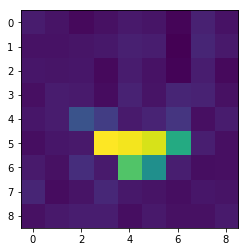

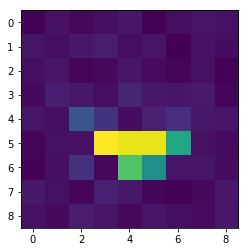

In [11]:
import matplotlib.pyplot as plt
plt.imshow(y1[0])
plt.show()
plt.imshow(y2[0])
plt.show()

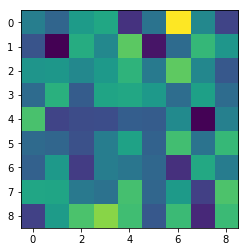

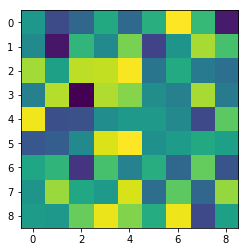

In [18]:
import matplotlib.pyplot as plt
plt.imshow(y1[0])
plt.show()
plt.imshow(y2[0])
plt.show()

In [32]:
from visualize import make_dot
import torch
from densenet import densenet121_racnn_gl
x = torch.autograd.Variable(torch.randn(1, 3, 299, 299))
x = x.cuda()

In [33]:

model_ft = densenet121_racnn_gl(use_gpu=True)
model_ft.cuda()

[ConvOnly] Using DenseNet as feature extractor
[ConvOnly] Using DenseNet as feature extractor


DenseNet_RACNN_GL (
  (glimpse): DenseNet_RACNN_Glimpse_Extractor (
    (conv1): DenseNet (
      (features): Sequential (
        (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
        (relu0): ReLU (inplace)
        (pool0): MaxPool2d (size=(3, 3), stride=(2, 2), padding=(1, 1), dilation=(1, 1))
        (denseblock1): _DenseBlock (
          (denselayer1): _DenseLayer (
            (norm.1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True)
            (relu.1): ReLU (inplace)
            (conv.1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (norm.2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True)
            (relu.2): ReLU (inplace)
            (conv.2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          )
          (denselayer2): _DenseLayer (
            (norm.1): BatchNorm2d(96, eps=1e-05, mo

In [40]:
y, _ = model_ft(x)

In [43]:
t = make_dot(y)
dir(t)
t.format = 'png'
t.render()

'Digraph.gv.png'

In [39]:
y

(Variable containing:
 
 Columns 0 to 9 
 -0.0738 -0.2201 -0.0950 -0.0154  0.0361 -0.2877  0.2383 -0.0881  0.4890 -0.1637
 
 Columns 10 to 19 
 -0.0835 -0.0903  0.0134  0.3150  0.3030  0.1899 -0.2833  0.4202 -0.1801  0.0083
 
 Columns 20 to 29 
 -0.1584  0.0785 -0.0243 -0.1759  0.1239  0.3527 -0.1026 -0.0379 -0.4745 -0.2637
 
 Columns 30 to 39 
 -0.0221 -0.3015  0.2500 -0.1827 -0.0640 -0.0490  0.0384  0.0516 -0.3374  0.0298
 
 Columns 40 to 49 
  0.0382 -0.0955 -0.0382 -0.1721  0.2421  0.0037 -0.3588  0.1243  0.2621 -0.0255
 
 Columns 50 to 59 
 -0.1919 -0.2501 -0.2353  0.1891 -0.3552  0.6324  0.1023  0.0809  0.1059  0.0722
 
 Columns 60 to 69 
 -0.0518  0.1141 -0.1722 -0.1608 -0.1898  0.1020 -0.3278 -0.2054 -0.1626 -0.0628
 
 Columns 70 to 79 
 -0.0298 -0.1230 -0.2127 -0.0513 -0.2628 -0.0225 -0.1762  0.1949  0.0835  0.2710
 
 Columns 80 to 89 
  0.0318  0.1612  0.3485  0.2485 -0.0106  0.1156 -0.0815 -0.1003  0.3123 -0.2496
 
 Columns 90 to 99 
 -0.0035  0.0476 -0.1186 -0.0299 -0.1630 

In [47]:
from graphviz import Digraph
from torch.autograd import Variable


def make_dot(var, params=None):
    """ Produces Graphviz representation of PyTorch autograd graph

    Blue nodes are the Variables that require grad, orange are Tensors
    saved for backward in torch.autograd.Function

    Args:
        var: output Variable
        params: dict of (name, Variable) to add names to node that
            require grad (TODO: make optional)
    """
    if params is not None:
        assert isinstance(params.values()[0], Variable)
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="800, 800"))
    seen = set()

    def size_to_str(size):
        return '('+(', ').join(['%d' % v for v in size])+')'

    def add_nodes(var):
        if var not in seen:
            if torch.is_tensor(var):
                dot.node(str(id(var)), size_to_str(var.size()), fillcolor='orange')
            elif hasattr(var, 'variable'):
                u = var.variable
                name = param_map[id(u)] if params is not None else ''
                node_name = '%s\n %s' % (name, size_to_str(u.size()))
                dot.node(str(id(var)), node_name, fillcolor='lightblue')
            else:
                dot.node(str(id(var)), str(type(var).__name__))
            seen.add(var)
            if hasattr(var, 'next_functions'):
                for u in var.next_functions:
                    if u[0] is not None:
                        dot.edge(str(id(u[0])), str(id(var)))
                        add_nodes(u[0])
            if hasattr(var, 'saved_tensors'):
                for t in var.saved_tensors:
                    dot.edge(str(id(t)), str(id(var)))
                    add_nodes(t)
    add_nodes(var.grad_fn)
    return dot
                     

In [12]:
"""
111
222
333

123
123
123

"""

torch.arange(1, 11)



  1
  2
  3
  4
  5
  6
  7
  8
  9
 10
[torch.FloatTensor of size 10]

In [13]:
m1 = torch.randn(5,5)

In [17]:
t = m1[:,2:4].contiguous()
t.view(-1)


-0.6280
-0.8029
 0.0128
 0.4159
-0.6270
 0.2475
-1.0389
 1.7360
-0.0353
 0.5048
[torch.FloatTensor of size 10]

In [ ]:
torch.zeros(3,5)